# Isogeometric analysis of the non-linear time-dependent Poisson equation using the implicit time step.

#### In this section, we test Newton's method and implicit time scheme.

## 1. Nonlinear Poisson Equation

  Let $\Omega\subset\mathbb{R}^d$ be an open set with sufficiently smooth boundary, denoted by $\Gamma$, where $d=2$ is the number of spatial dimensions. Then, the problem stated in strong form as :

Find $\mathbf{c} :\overline{\Omega}\times(0,T)\longmapsto\mathbb{R}$ such that 
## $	\begin{align*}
		\left\lbrace\begin{array}{lll}
			 -\nabla \cdot \nabla\mathbf{u}~~~~~=~ f&\text{ in } \Omega ,~~~~~~~~~~(1)\\
		    \mathbf{u}~~~~~~~~~~~~~~~~~ =~ g &\text{ on } \Gamma_g,~~~~~~~~(2)\\
		\end{array}\right.
	\end{align*}$
 Where (2) is defined by a control points 

## 2. Variational form and discrete formulation

Let X be the functional space and $\big(.,.\big)_\Omega$ denote the $L^2$ inner product with respect to  $\Omega$. The variational formulation is stated as follows :

Find $\mathbf{u}\in X$, such that $\forall~w\in X$ : 

$$\textbf{B}\big(w,\mathbf{u}\big) = \mathbf{L}(w) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(8)$$

with

$$\begin{align*}\textbf{B}\big(w,\mathbf{v}\big) &= \big(\nabla
w,\nabla\mathbf{v}\big)_\Omega.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(9)\\
\textbf{L}\big(w\big) &= \big(w,f\big)_\Omega .~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)
\end{align*}$$

The space discretization of (11) leads to the following variational problem over the finite element spaces : 

Find $\mathbf{u}^h \in X^h\subset X$, such that $\forall~w^h \in X^h$ : 

$$\textbf{B}\big(w^h, \mathbf{u}^h\big) = \textbf{L}\big(w^h\big) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)$$

where 

$$\mathbf{u}^h = \sum_{i=1}^{n_b} \mathbf{u}_iN_i, ~~~ w^h = \sum_{i=1}^{n_b} w_iN_i~~~~~~~~~~~~~~~~~~~~~~~~~~~~(11)$$

$n_b$ is the dimension of discrete space.

# 5. Numerical implementation under psydac.

$\textit{TODO}$

In [66]:
from sympy import pi, cos, sin, exp, log, symbols
from sympy.utilities.lambdify import implemented_function
import pytest

from sympde.calculus import grad, dot
from sympde.calculus import laplace
from sympde.topology import ScalarFunctionSpace
from sympde.topology import element_of
from sympde.topology import NormalVector
from sympde.topology import Square
from sympde.topology import Union
from sympde.expr     import BilinearForm, LinearForm, integral
from sympde.expr     import Norm
from sympde.expr     import find, EssentialBC
from sympde.expr.expr import linearize
from sympde.core     import Constant

from psydac.fem.basic          import FemField
from psydac.api.discretization import discretize

x,y,z = symbols('x1, x2, x3')

In [67]:
# ..Topological domain
domain = Square()
B_dirichlet_0 = domain.boundary

In [68]:
# ..Function Space
V  = ScalarFunctionSpace('V', domain)

#...
degree = [2,2]       #.. degree = 2, 3
ncells = [2**6,2**6] #.. ncells= 2**4,5,6

In [69]:
# .. Defining the Linear form $G$
u  = element_of(V, name='u')
v  = element_of(V, name='v')
#.. Tools of Poisson equation
#.. for non symetric solution (Pc)
solution = sin(3.*pi*y)*(x+0.5)**2
f        = 9*pi**2*(x + 0.5)**2*sin(3*pi*y) - 2*sin(3*pi*y)
#.. for POlynomial (Pc_poly)
#solution = x*(1.-x)*y*(1.-y)
#f        = 2.*y*(1.-y) + 2.*x*(1.-x)

In [70]:
#... Dirichlet (us is free parameter and must be provided later)
ud  = element_of(V, name='ud')
# Linear form l: V --> R
l = LinearForm(v, integral(domain, f * v - dot(grad(ud), grad(v))))

In [71]:
# Bilinear form a: V x V --> R
a = BilinearForm((u, v), integral(domain, dot(grad(u), grad(v)) ))

In [72]:
bc = [EssentialBC(u,    0., domain.boundary)]
equation = find(u, forall=v, lhs=a(u, v), rhs=l(v), bc= bc)
# Create computational domain from topological domain
from mpi4py import MPI
domain_h = discretize(domain, ncells=ncells, comm=MPI.COMM_WORLD)

# Discrete spaces
Vh = discretize(V, domain_h, degree=degree)

# Discretize equation using Dirichlet bc
equation_h = discretize(equation, domain_h, [Vh, Vh])

In [74]:
# First guess: zero solution
u_dh  = FemField(Vh)
nbasis = [ncells[0]+degree[0], ncells[1]+degree[1]]
from numpy import loadtxt 
xd = loadtxt('Pc_'+str(degree[0])+'_'+str(ncells[0])+'.txt')
#print(xd)
u_dh.coeffs[0:nbasis[0],0:nbasis[0]] = xd[:,:]

In [75]:
# Solve linear system
u_h = equation_h.solve(ud = u_dh)

# ... Assemble Dirichlet
u_h.coeffs[0:nbasis[0],0:nbasis[0]] += xd[:,:]
# Error norms
error  = u - solution
l2norm = Norm(error, domain, kind='l2')
# Discretize error norms
l2norm_h = discretize(l2norm, domain_h, Vh)
print('le-error = ', l2norm_h.assemble(u=u_h))

le-error =  0.0002091829117190997


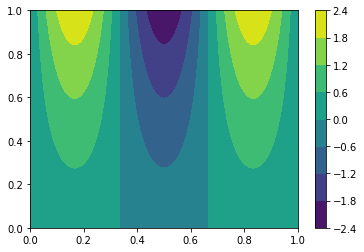

In [76]:
from matplotlib import pyplot as plt
from simplines import plot_field_2d
nbasis = [w.nbasis for w in Vh.spaces]
p1,p2 = Vh.degree
x = u_h.coeffs._data[p1:-p1,p2:-p2]
u = x.reshape(nbasis)
plot_field_2d(Vh.knots, Vh.degree, u) ; plt.colorbar()